## Calculating the average number of curves at each timestep

with different values of $\mu_{min}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.optimize import root_scalar
from scipy import stats
import pandas as pd

In [2]:
class Curve:
    def __init__(self, k_T, lambda_1, t=0):
        self.a = k_T
        self.b = -lambda_1
        self.t = t
        ## a log(mu) + b(mu-1)
        ## t contains time offset, because lambda_1 is incorporated into b.
    
    def __repr__(self):
        return f'Curve: {self.a} log(mu) + {self.b} (mu-1), t={self.t}.'
    
    def evaluate(self, mu):
        return np.maximum(self.a*np.log(mu) + self.b*(mu-1), 0)
    
    def update(self, k_T, lambda_1):
        return Curve(self.a + k_T, -self.b + lambda_1, self.t-1)
    
    def ymax(self):
        return self.evaluate(self.xmax())
    
    def xmax(self):
        return -self.a/self.b
    
    def less_than(self, min_param):
        #returns true if only positive on mu<mu_min
        return -self.a/self.b < min_param
    
    def dominates(self, other_curve):
        self_root = -self.a/self.b #other non mu=1 root: the curve's "length"
        other_root = -other_curve.a/other_curve.b
        self_slope = self.a + self.b  #slope at mu=1: the curve's "height"
        other_slope = other_curve.a + other_curve.b
        return (self_root > other_root)and(self_slope > other_slope)

In [3]:
def focus_step(curve_list, k_T, lambda_T, min_param=1):
    new_curve_list = []
    global_max = 0
    time_offset = 0
    
    if not curve_list: #list is empty
        
        if k_T <= lambda_T:
            return new_curve_list, global_max, time_offset
        else:
            updated_c = Curve(k_T, lambda_T, t=-1)
            new_curve_list.append(updated_c)
            global_max = updated_c.ymax()
            time_offset = updated_c.t
            
    else: #list not empty: go through and prune
        
        updated_c = curve_list[0].update(k_T, lambda_T) #check leftmost quadratic separately
        if updated_c.less_than(min_param): #our leftmost quadratic is negative i.e. we have no quadratics
            return new_curve_list, global_max, time_offset
        else:
            new_curve_list.append(updated_c)
            if updated_c.ymax() > global_max:   #we have a new candidate for global maximum
                global_max = updated_c.ymax()
                time_offset = updated_c.t

            for c in curve_list[1:]+[Curve(0, 0)]:#add on new quadratic to end of list
                updated_c = c.update(k_T, lambda_T)

                if new_curve_list[-1].dominates(updated_c):
                    break #quadratic q and all quadratics to the right of it are pruned out by q's left neighbour
                elif updated_c.less_than(min_param):
                    pass #delete q and move on
                else:
                    new_curve_list.append(updated_c)

                    if updated_c.ymax() > global_max:   #we have a new candidate for global maximum
                        global_max = updated_c.ymax()
                        time_offset = updated_c.t
        
    return new_curve_list, global_max, time_offset

In [4]:
def plot_curves(curve_list, threshold=25, T=0):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("FOCuS step at detection time $T=67$")
    
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$S_{T}(\mu)$", rotation=0)
    
    ax.set_ylim(-1, threshold+1)
    ax.set_xlim(-0.2, 5.2)
    
    
    ax.axhline(threshold, color='C1')

    mu = np.linspace(0.2, 10, 100) #the x-axis for the plot
    
    for c in curve_list:
        ax.plot(mu, c.evaluate(mu), label=f'$\\tau={c.t+T+1}$')
    
    ax.axhline(0, color='C0')

    if curve_list:
        ax.legend(loc='upper left')
    return fig

def focus(X, lambda_1, threshold, mu_min=1, plot=False):
    
    if mu_min>1:
        min_param = (mu_min-1)/np.log(mu_min)
    else:
        min_param=1
    
    if np.ndim(lambda_1)==0:#scalar
        lambda_1 = np.full(X.shape, lambda_1)
        
    number_of_curves = []
    
    curve_list = []
    for T in range(len(X)):
        curve_list, global_max, time_offset = focus_step(curve_list, X[T], lambda_1[T], min_param)
        number_of_curves.append(len(curve_list))
        
        if plot:
            clear_output(wait=True)
            plot_curves(curve_list, threshold, T)
            plt.show()
        
        if global_max > threshold:
            
            clear_output(wait=True)
            plot_curves(curve_list, threshold, T)
            plt.savefig('plots/poisson_focus_internals.png', dpi = 150)
            plt.show()
            
            return global_max, time_offset+T+1, T, number_of_curves
        
        
        
    return 0, len(X)+1, len(X), number_of_curves #no change found by end of signal

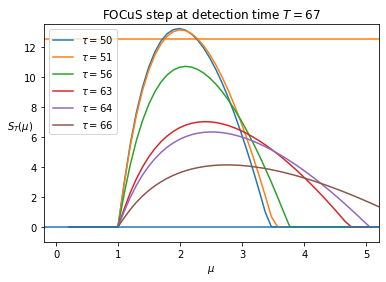

In [5]:
from scipy import stats
np.random.seed(42)
threshold=12.5
X = np.concatenate((stats.poisson(mu=2).rvs(size=50), stats.poisson(mu=4).rvs(size=50)))

significance, changepoint, stopping_time, _ = focus(X, lambda_1=2, threshold=threshold, mu_min=1.5, plot=False)


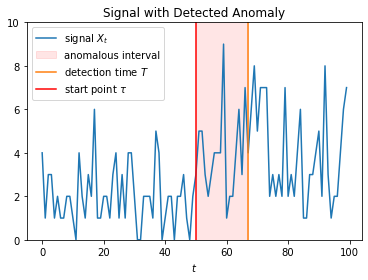

In [8]:
plt.plot(X, label="signal $X_t$")
plt.title("Signal with Detected Anomaly")
plt.xlabel("$t$")
if changepoint is not None:
    plt.fill((changepoint, stopping_time, stopping_time, changepoint), (-5, -5, 15, 15), color="red", alpha=0.1, label="anomalous interval") 
    plt.axvline(stopping_time, color='C1', label="detection time $T$")
    plt.axvline(changepoint, color='red', label="start point $\\tau$")
    plt.ylim(0, 10)
    
    plt.savefig('plots/poisson_focus_internals.png', dpi = 150)
    plt.legend()

## Plot of number of curves versus number of windows (unconstrained)

In [7]:
#unconstrained case
sim_size=1000
λ = 100
time=10000

unconstrained_df = pd.DataFrame()

for sim in range(sim_size):

    np.random.seed(sim)
    X = stats.poisson(mu=λ).rvs(size=time)

    _, __, __, number_of_curves = focus(X, lambda_1=λ, threshold=np.inf, plot=False)
    unconstrained_df[sim] = number_of_curves

unconstrained_df['mean'] = unconstrained_df.mean(axis='columns')

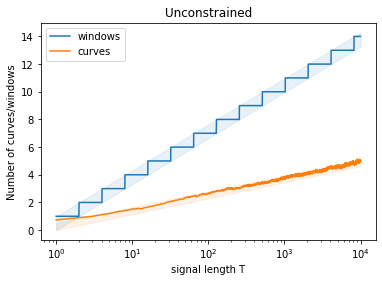

In [10]:
time_array = np.arange(1, time)

time_array_windows = np.concatenate([np.linspace(1, 100, 10000), np.arange(100, time)])
number_of_windows = np.floor(np.log2(time_array_windows))+1
plt.plot(time_array_windows, number_of_windows, color='C0', label="windows")
plt.fill_between(time_array, y1=np.log2(time_array), y2=np.log2(time_array)+1, color="C0", alpha=0.1)

expected_curves = np.log(time_array)/2
plt.plot(unconstrained_df['mean'][1:], color='C1', label='curves')
plt.fill_between(time_array, y1=expected_curves, y2=expected_curves+0.5, color="C1", alpha=0.1)

plt.xscale('log')
plt.title("Unconstrained")
plt.xlabel("signal length T")
plt.ylabel("Number of curves/windows")
plt.legend()

plt.savefig('plots/unconstrained_cost.png', dpi = 150)
plt.show()

## Plot of number of curves versus number of windows (constrained)

In [12]:
threshold=12.5
def switcher(λh, threshold=threshold, x=4):
    #solves λh(μ*np.log(μ)-μ+1)=threshold for μ
    return root_scalar(lambda μ, z: μ*np.log(μ)-μ+1-z, args = (threshold/λh), bracket=[1+np.sqrt(threshold/λh), x]).root


sim_size=1000
λ = 100
h_max=1024
time=10000
μ_min = switcher(λ*h_max, threshold=5**2/2, )

constrained_df = pd.DataFrame()

for sim in range(sim_size):

    np.random.seed(sim)
    X = stats.poisson(mu=λ).rvs(size=time)

    _, __, __, number_of_curves = focus(X, lambda_1=λ, threshold=np.inf, mu_min=μ_min, plot=False)
    constrained_df[sim] = number_of_curves

constrained_df['mean'] = constrained_df.mean(axis='columns')

C:\Users\wardk3\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


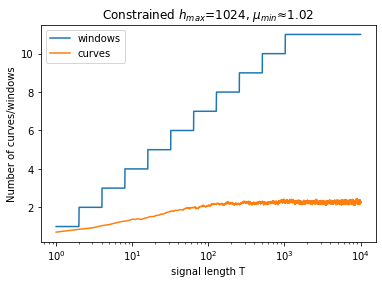

In [13]:
#logarithmic
time_array = np.arange(1, time)

time_array_windows = np.concatenate([np.linspace(1, 100, 10000), np.arange(100, time)])
number_of_windows = np.floor(np.log2(np.minimum(time_array_windows, h_max)))+1
plt.plot(time_array_windows, number_of_windows, color='C0', label="windows")
#plt.fill_between(time_array, y1=np.log2(time_array), y2=np.log2(time_array)+1, color="C0", alpha=0.1)


expected_curves = np.log(time_array)/2
plt.plot(constrained_df['mean'][1:], color='C1', label='curves')
#plt.fill_between(time_array, y1=expected_curves, y2=expected_curves+1, color="C1", alpha=0.1)


plt.xscale('log')
plt.title("Constrained $h_{max}$="+f"{h_max}"+", $μ_{min}$≈"+f"{round(μ_min, 2)}")
plt.xlabel("signal length T")
plt.ylabel("Number of curves/windows")
plt.legend()

plt.savefig('plots/constrained_cost.png', dpi = 150)
plt.show()

## Convex Minorant Graph

Text(0.5, 1.0, 'Locations of Changepoint Candidates compared to $Z_t-t\\lambda$')

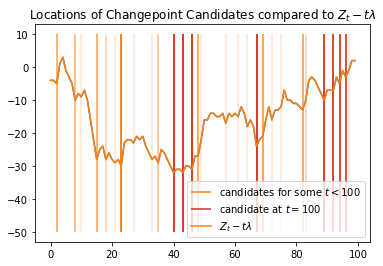

In [6]:
np.random.seed(11)

λ=10
size=100

signal = stats.poisson.rvs(mu=λ, size=size)
offset = np.full(shape=size, fill_value=-λ)

random_walk = signal.cumsum() + offset.cumsum()

plt.plot(random_walk)

def focus_find_curves(X, lambda_1, threshold, plot=False):
    if np.ndim(lambda_1)==0:#scalar
        lambda_1 = np.full(X.shape, lambda_1)
    
    output = []
    
    curve_list = []
    for T in range(len(X)):
        curve_list, global_max, time_offset = focus_step(curve_list, X[T], lambda_1[T])
        
        curve_start_times = []
        for curve in curve_list:
            curve_start_times.append(curve.t+T+1)
        
        output.append(curve_start_times)
        
        if global_max > threshold:
            return global_max, time_offset+T+1, T
        
    return output

curve_list = focus_find_curves(signal, lambda_1=λ, threshold=1000)

plt.vlines(40, -50, 10, color="C1", alpha=1, label="candidates for some $t<100$")

for T in curve_list:
    changepoint_candidates = np.array(T)-1
    plt.vlines(changepoint_candidates, -50, 10, color="C1", alpha=0.2)
    
E = curve_list[-1]
changepoint_candidates = np.array(E)-1
plt.vlines(changepoint_candidates, -50, 10, color="C3", label="candidate at $t=100$")

plt.plot(random_walk, label="$Z_t-t\lambda$")

plt.legend(loc="lower right")
plt.title("Locations of Changepoint Candidates compared to $Z_t-t\lambda$")